# Bibliotheken importieren

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Union
from tqdm import tqdm_notebook

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Daten lesen

In [19]:
df = pd.read_csv('/content/AusAntidiabeticDrug.csv')

In [20]:
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [22]:
# Insgesamt verbessert die Konvertierung einer Zeitspalte von einem Objekttyp in einen Zeittyp die Datenkonsistenz, ermöglicht effiziente zeitbasierte Vorgänge und erleichtert die Kompatibilität mit zeitbezogenen Bibliotheken und Frameworks.
df['ds'] = pd.to_datetime(df["ds"])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      204 non-null    datetime64[ns]
 1   y       204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


# Problemfall:

Johns Manager hat einige Daten gesammelt und ihn gebeten, aus den Daten Erkenntnisse zu gewinnen. Beschreibung des Datensatzes: Gesamte monatliche Skripte für pharmazeutische Produkte, die unter den ATC-Code A10 fallen, wie von der Australian Health Insurance Commission erfasst. Die Daten stammen von Juli 1991 bis Juni 2008 und werden monatlich erfasst. Was sollte John Ihrer Meinung nach im ersten Fall tun?

# Visualisierung der Serie

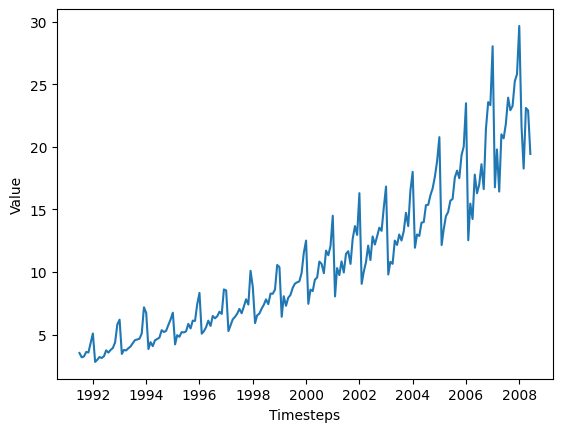

In [24]:
# Es gibt einen klaren Trend und eine klare Saisonalität. Wir können eine 12-Monats-Saisonalität erkennen
plt.plot(df["ds"],df["y"]);
plt.xlabel('Timesteps');
plt.ylabel('Value');


# # Zersetzung

Anhand der Zerlegung können wir Saisonalität und Trends erkennen

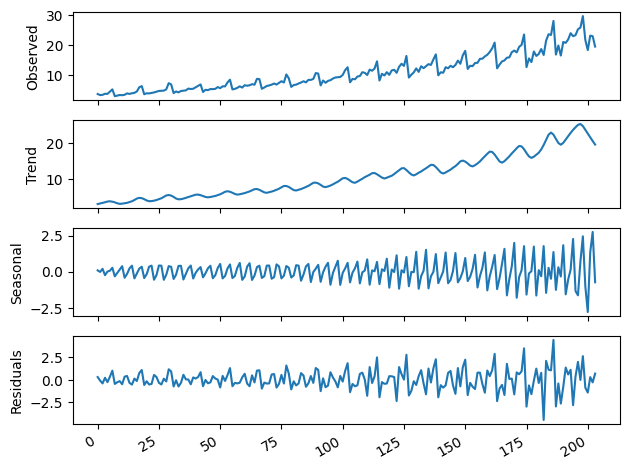

In [25]:
# Zersetzung

advanced_decomposition = STL(df.y, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

# Dickey-Adfuller-Test

Wir wenden diesen Test an, um festzustellen, ob die Daten stationär oder instationär sind. Wenn:
* p-Wert < 0,05 = Daten sind stationär
* p-Wert > 0,05 = Daten sind instationär

In [26]:
def adfuller_test(y):
    adf_result = adfuller(y)

    print("ADF Statistic:", adf_result[0])
    print("P-Value:", adf_result[1])


# Daten sind nicht stationär
adfuller_test(df.y)


ADF Statistic: 3.145185689306745
P-Value: 1.0


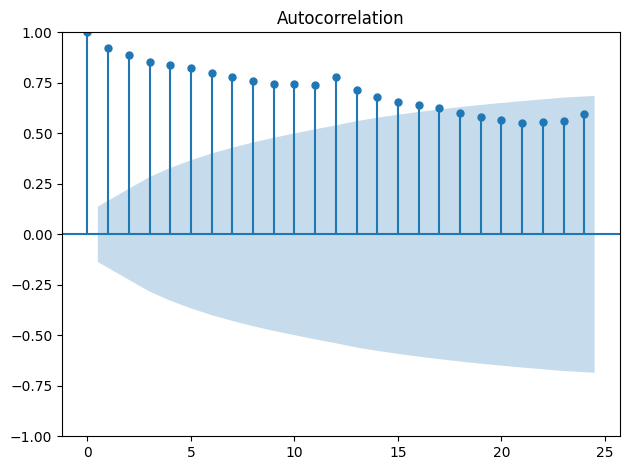

In [27]:
plot_acf(df.y)

plt.tight_layout()

Wir haben eine Transformation angewendet, um die Daten stationär zu machen, und den Adfuller-Test wiederholt

In [28]:
df_diff = np.diff(df.y, n=1)

In [29]:
# immer noch instationär
adfuller_test(df_diff)


ADF Statistic: -2.4951721474497903
P-Value: 0.1166534168646754


Als Ergebnis des Adfuller-Tests können wir sehen, dass der p-Wert größer als 0,05 ist, sodass die Daten instationär sind und die Transformation nicht funktioniert hat. Aus diesem Grund werden wir eine zweite Transformation anwenden. Jetzt werden wir dies jedoch je nach Saisonalität tun.

In [30]:
df_diff2 = np.diff(df_diff, n=12)

In [31]:
# stationär
adfuller_test(df_diff2)



ADF Statistic: -19.84844009618371
P-Value: 0.0


Nach der zweiten Transformation, bei der wir den Adfuller-Test angewendet haben, können wir sehen, dass der p-Wert nicht größer als 0,05 ist, sodass wir die Nullhypothese ablehnen und sagen können, dass die Daten stationär sind.

Aufgrund dieser Transformationen:
* d: 1
* D: 1

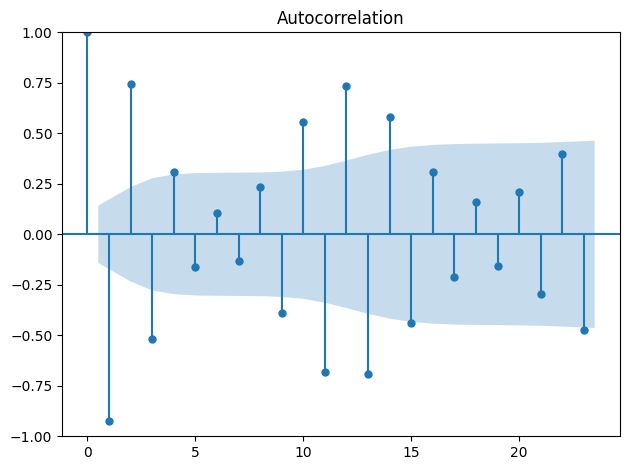

In [32]:
plot_acf(df_diff2)

plt.tight_layout()

In [33]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    # this function try combinations and give them with their AIC values

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [34]:
train = df[:168]
test = df[168:]

In [35]:
# combinations for all parameters
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12   # We have monthly data, so 12 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['y'], SARIMA_order_list, d, D, s)

<ipython-input-33-fbd07a2ebd23>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

In [36]:
# Wir wählen die Parameter mit dem niedrigsten AIC

SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 3)",26.618683
1,"(3, 1, 1, 3)",270.951096
2,"(3, 3, 1, 3)",271.452692
3,"(3, 2, 1, 3)",272.222636
4,"(3, 3, 0, 1)",272.580413
...,...,...
251,"(0, 0, 3, 1)",351.425175
252,"(0, 0, 1, 1)",351.466837
253,"(0, 0, 0, 1)",354.751719
254,"(0, 0, 1, 0)",357.173706


In [37]:
# Anpassen des Modells mit den besten Parametern

SARIMA_model = SARIMAX(train['y'], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Sun, 16 Jul 2023   AIC                            270.951
Time:                                            12:08:07   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.091      0.748      0

* Im Diagramm oben links können wir sehen, dass die Residuen keinen zeitlichen Trend aufweisen und die Varianz konstant zu sein scheint
* Oben rechts und links unten sehen wir, dass die Verteilungen der Residuen nahe an der Normalverteilung liegen
* Schließlich können wir im Korrelogramm sehen, dass es keinen signifikanten Koeffizienten gibt

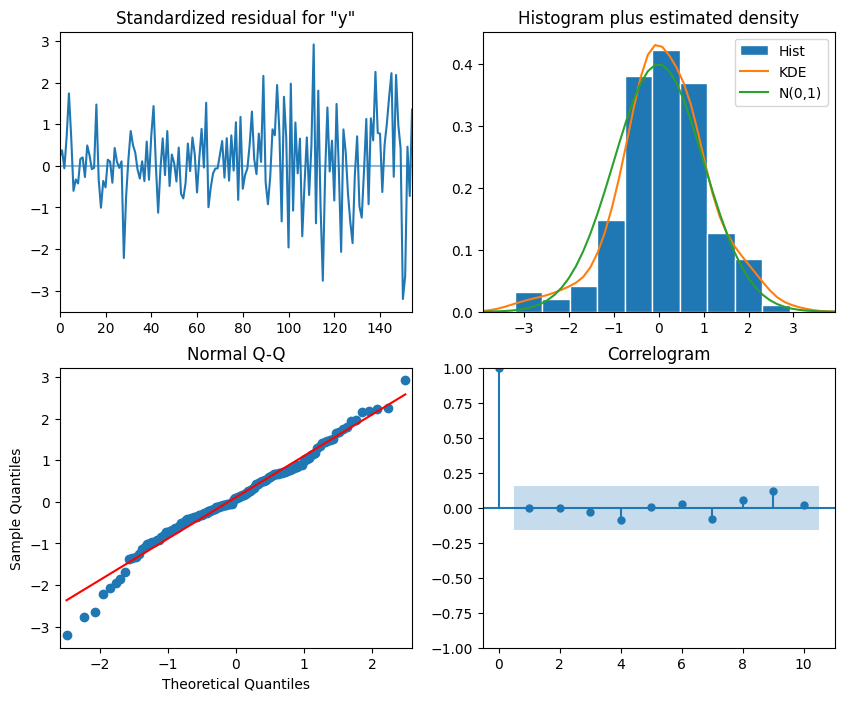

In [38]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [39]:
residuals = SARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.436662,0.508738
2,0.627295,0.730777
3,0.645812,0.885869
4,2.257935,0.688438
5,2.949867,0.707715
6,3.388715,0.758712
7,9.981340,0.189633
8,10.591223,0.225954
9,11.853030,0.221722
10,11.984391,0.286102


In [40]:
SARIMA_pred = SARIMA_model_fit.get_prediction(168, 204).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

<ipython-input-40-6d5177e601e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


,ds,y,SARIMA_pred
168,2005-07-01,15.829550,16.745954
169,2005-08-01,17.554701,16.619418
170,2005-09-01,18.100864,17.255357
171,2005-10-01,17.496668,18.107603
172,2005-11-01,19.347265,18.722355
173,2005-12-01,20.031291,19.885765
174,2006-01-01,23.486694,22.216633
175,2006-02-01,12.536987,13.544400
176,2006-03-01,15.467018,14.972349
177,2006-04-01,14.233539,15.593447


In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
mape_SARIMA = mape(test['y'], test['SARIMA_pred'])

print(mape_SARIMA)

9.32718774352661


In [43]:
df = df.set_index("ds")
df

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [44]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)    # Set the right SARIMA parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [45]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2    # Use a window of 2, just like in chapter 6

pred_df = df[168:]

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_SARIMA'] = pred_SARIMA

pred_df.head()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

,y,pred_mean,pred_last_value,pred_SARIMA
ds,,,,
2005-07-01,15.829550,8.644007,15.705248,16.745954
2005-08-01,17.554701,8.644007,15.705248,16.619418
2005-09-01,18.100864,8.738691,17.554701,17.054098
2005-10-01,17.496668,8.738691,17.554701,18.168144
2005-11-01,19.347265,8.844040,17.496668,19.153000


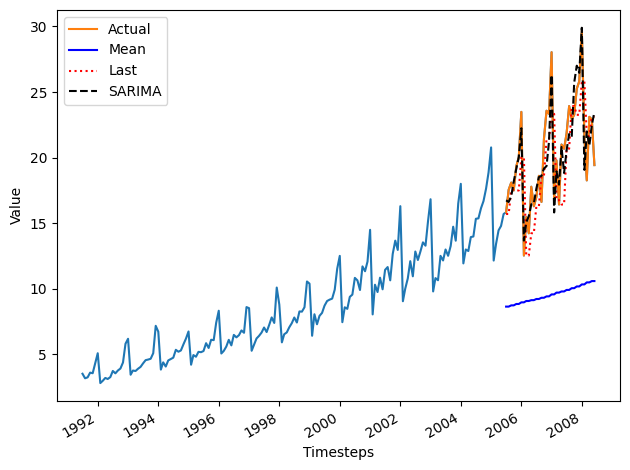

In [46]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df['y'], label='Actual')
ax.plot(pred_df['pred_mean'], 'b-', label='Mean')
ax.plot(pred_df['pred_last_value'], 'r:', label='Last')
ax.plot(pred_df['pred_SARIMA'], 'k--', label='SARIMA')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

#ax.axvspan(168, 204, color='#808080', alpha=0.2)

#plt.xlim(8000, 10000)
fig.autofmt_xdate()
plt.tight_layout()

127.07902984193957 9.238796907681897 3.1004378059751425


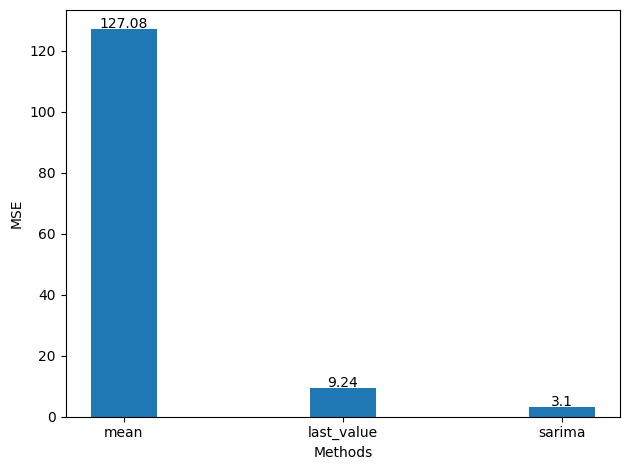

In [47]:
mse_mean = mean_squared_error(pred_df['y'], pred_mean)
mse_last = mean_squared_error(pred_df['y'], pred_last_value)
mse_sarima= mean_squared_error(pred_df['y'], pred_SARIMA)

print(mse_mean, mse_last, mse_sarima)

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'sarima']
y = [mse_mean, mse_last, mse_sarima]

ax.bar(x, y, width=0.3)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.5, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [50]:
import warnings
warnings.filterwarnings('ignore')

tss = pd.read_csv("/content/AusAntidiabeticDrug.csv")
tss["ds"] = pd.to_datetime(tss["ds"])
tss.index = tss["ds"]
tss = tss[["y"]]
print(tss.shape)
tss.head()

(204, 1)


,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [51]:
## Using month as a feature
tss['month'] = [tss.index[i].month for i in range(len(tss))]
## From the insights in session-1
#There is a large jump in sales in January each year.
tss["Jan"] = tss["month"].apply(lambda x: 1 if x == 1 else 0)

# From box-plot shown session-1
tss["Dec"] = tss["month"].apply(lambda x: 1 if x == 12 else 0)
tss["Feb"] = tss["month"].apply(lambda x: 1 if x == 2 else 0)
tss["June"] = tss["month"].apply(lambda x: 1 if x == 6 else 0)

## Using lag-1 variable - From Auto-Correlation Plot.
tss["lag1"] = tss.y.shift(1)

## Using the trend
tss["Trend"] = [i for i in range(len(tss))]
tss = tss.fillna(0)
tss.head()

,y,month,Jan,Dec,Feb,June,lag1,Trend
ds,,,,,,,,
1991-07-01,3.526591,7,0,0,0,0,0.000000,0
1991-08-01,3.180891,8,0,0,0,0,3.526591,1
1991-09-01,3.252221,9,0,0,0,0,3.180891,2
1991-10-01,3.611003,10,0,0,0,0,3.252221,3
1991-11-01,3.565869,11,0,0,0,0,3.611003,4


In [54]:
## Split the data into train and test
x_train = tss[tss.index <datetime.datetime(2005, 1, 1, 0, 0, 0)]
x_test = tss[tss.index >=datetime.datetime(2005, 1, 1, 0, 0, 0)]
print(x_train.shape, x_test.shape)

(162, 8) (42, 8)


In [53]:
import datetime


In [57]:
### Since there is a mulitiplicative effect. Use log of y instead of direct y
x_train["y"] = x_train["y"].apply(lambda x: math.log(x+1))
x_train["lag1"] = x_train["lag1"].apply(lambda x: math.log(x+1))

x_test["lag1"] = x_test["lag1"].apply(lambda x: math.log(x+1))
x_train.head()

,y,month,Jan,Dec,Feb,June,lag1,Trend
ds,,,,,,,,
1991-07-01,1.509969,7,0,0,0,0,0.000000,0
1991-08-01,1.430524,8,0,0,0,0,1.509969,1
1991-09-01,1.447441,9,0,0,0,0,1.430524,2
1991-10-01,1.528445,10,0,0,0,0,1.447441,3
1991-11-01,1.518609,11,0,0,0,0,1.528445,4


In [56]:
import pandas as pd
import numpy as np
import datetime
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


In [58]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train[["Jan", "Feb", "June", "Dec", "lag1", "Trend"]], x_train.y)
pred = model.predict(x_test[["Jan", "Feb", "June", "Dec", "lag1",  "Trend"]])
measure = math.pow(mean_squared_error(x_test.y, [math.exp(i)-1 for i in pred]), 0.5)
print("RMSE:", measure)

RMSE: 1.9662146435161338


In [59]:
print("model.coef_: {}".format(model.coef_))
print("model.intercept_: {}".format(model.intercept_))

model.coef_: [ 0.238246   -0.22933591 -0.04837378  0.20326329  0.14559292  0.00705468]
model.intercept_: 1.2641645007080748


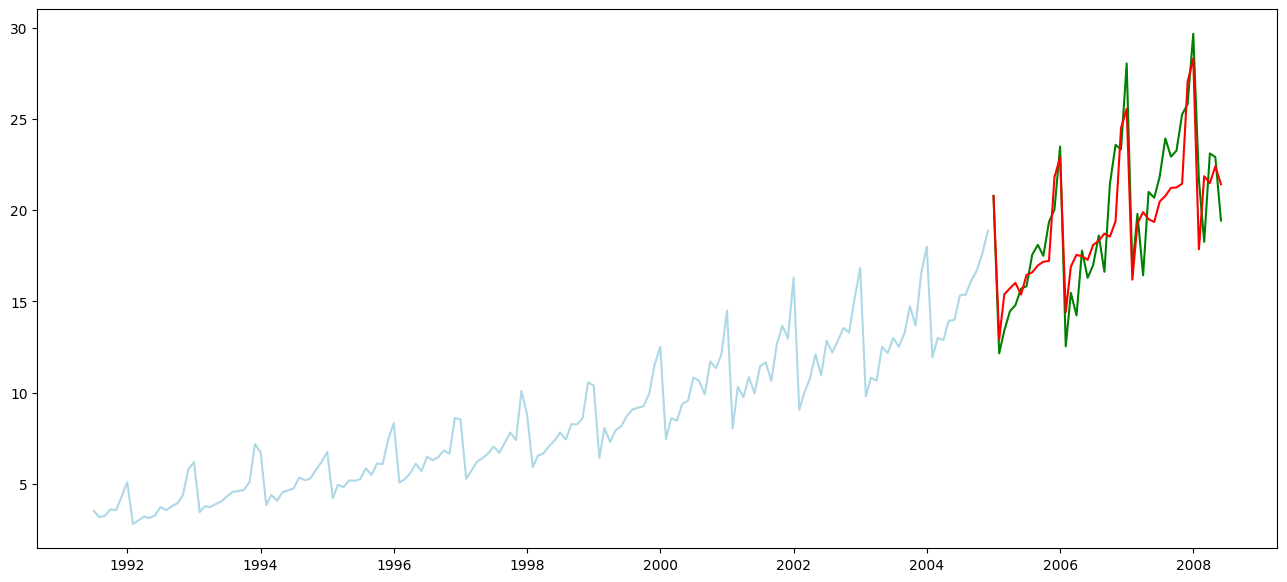

In [60]:
pred = pd.DataFrame(pred)
pred.columns = ["yhat"]
pred.index = x_test.index
pred.head()

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, [math.exp(i)-1 for i in x_train.y], color="lightblue")
plt.plot(x_test.index, x_test.y, color="green")
plt.plot(pred.index, [math.exp(i)-1 for i in pred.values], color="red")
plt.show()

Text(0.5, 1.0, 'Actual vs Predicted')

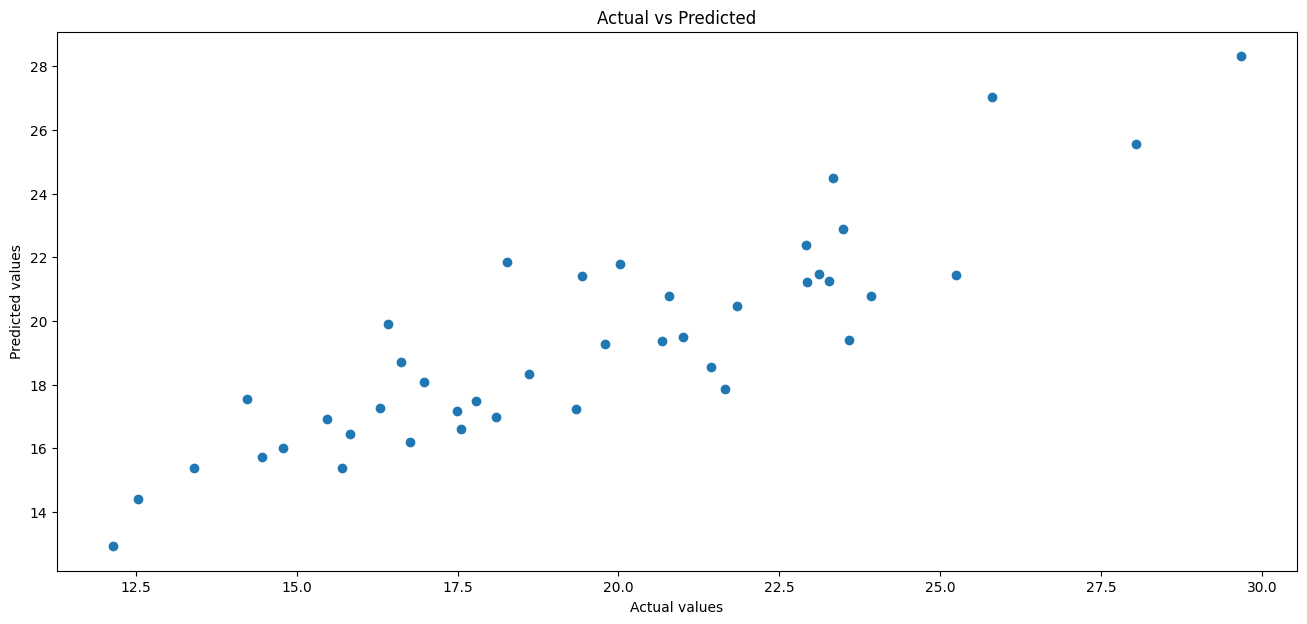

In [61]:
plt.figure(figsize=(16, 7))
plt.scatter(x_test["y"].values, [math.exp(i)-1 for i in pred["yhat"].values])
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")

Text(0.5, 1.0, 'Residual plots')

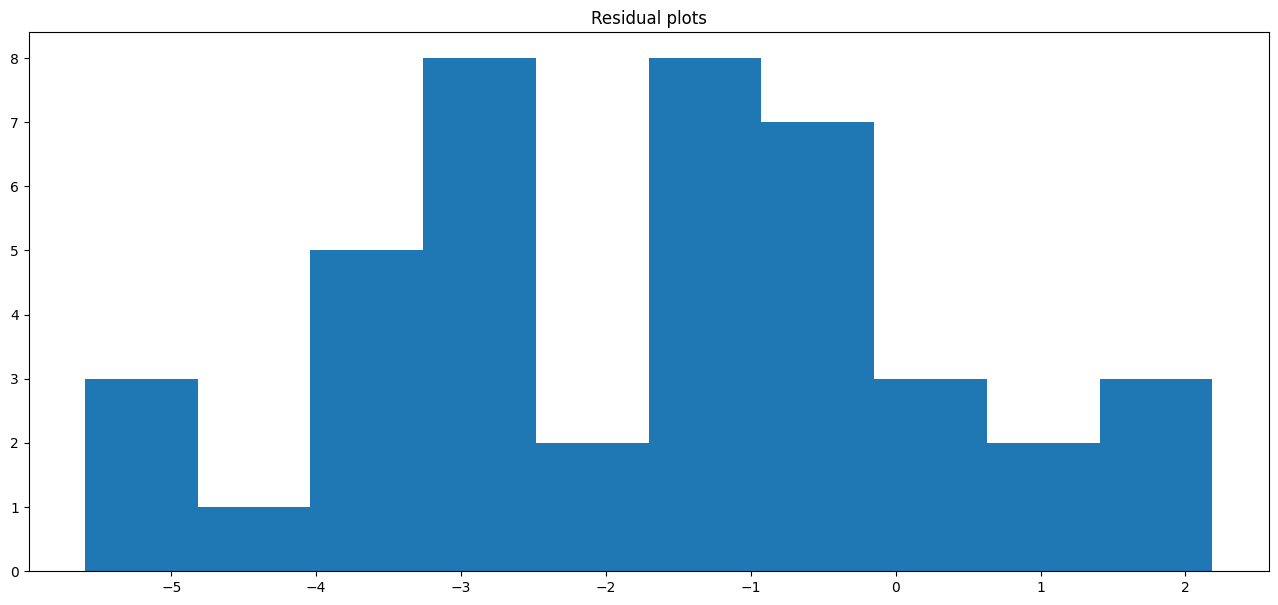

In [62]:
plt.figure(figsize=(16, 7))
plt.hist([j -  math.exp(i)-1 for i, j in zip(pred["yhat"].values, x_test.y)])
plt.title("Residual plots")

Text(0.5, 1.0, 'Residual Plots')

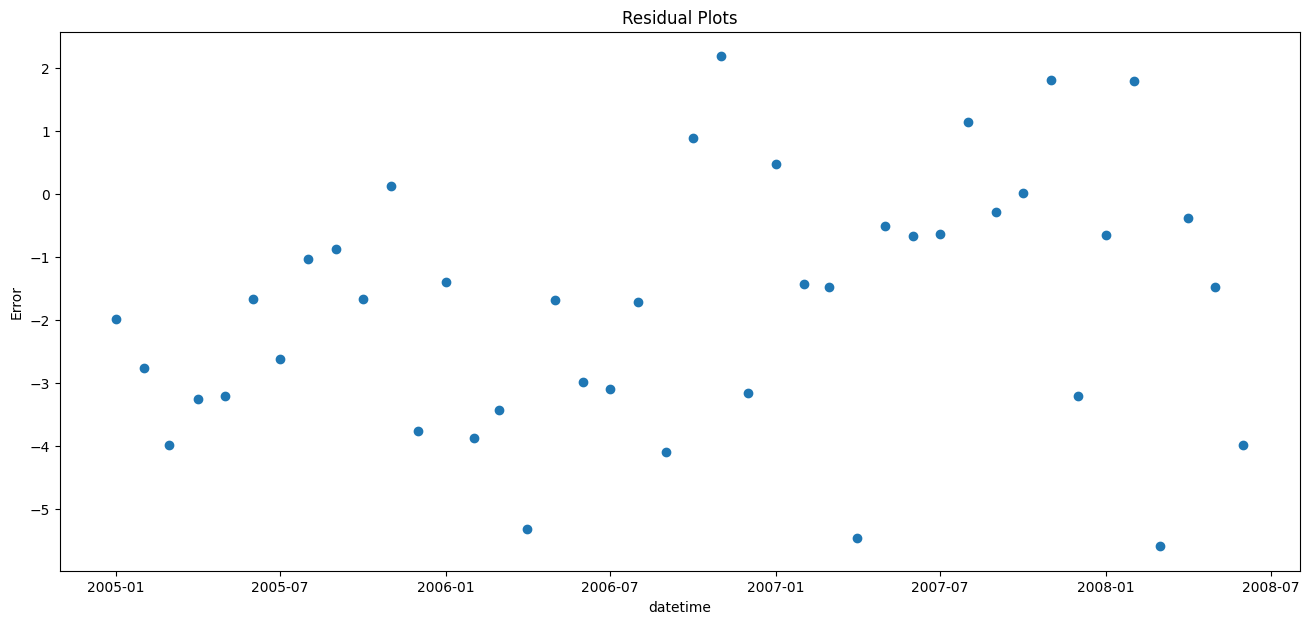

In [63]:
error = [j -  math.exp(i)-1 for i, j in zip(pred["yhat"].values, x_test.y)]
datetime = x_test.index

plt.figure(figsize=(16, 7))
plt.scatter(datetime, error)
plt.xlabel("datetime")
plt.ylabel("Error")
plt.title("Residual Plots")

## Einblicke:

* Die Fehler sind zufällig, haben einen konstanten Mittelwert und sind
normalverteilt.

* Mit einfacher linearer Regression und grundlegendem Feature-Engineering haben wir einen RMSE-Wert von 1,96 erreicht, was im Vergleich zu ARIMA-Modellen immer noch hoch ist, aber im Gegensatz zu Arima-Modellen können Sie Ihre Ergebnisse hier leicht interpretieren.

* Sorgfältiges Feature-Engineering und die Verwendung komplexer Modelle werden Ihren RMSE-Wert weiter reduzieren, aber das ist mit Kosten verbunden und Sie sollten zwischen Komplexität und Interpretierbarkeit wählen.